## Event Driven Simulation 

### Scheduling CoMP

In [14]:
import edsmodified as eds
import simpy
import numpy as np
import pandas as pd
import scipy
SCHEDULE_T=2
import matplotlib.pyplot as plt
import show as sh

In [15]:
env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
ue_list2=np.array([])
#define UEs

    
max_prb=50
thr=6
cluster=[19,20]

ue_nr=100

x=np.append(np.ones(ue_nr)*19,np.ones(ue_nr)*20)
y=np.append(np.ones(ue_nr)*20,np.ones(ue_nr)*19)
sinr=np.random.randint(-5,15,ue_nr*2)
sinr2=np.random.randint(0,18,ue_nr*2)

rt_nrt=np.array([])
rt_nrt=np.append(rt_nrt,np.ones(ue_nr*2)*0)

df=pd.DataFrame()
df['PCI Serving']=x
df['PCI Coord']=y
df['JT_1 SINR [lin]']=sinr
df['JT_2 SINR [lin]']=sinr2
df['usage']=rt_nrt
df['id']=np.arange(0,ue_nr*2)
   
df['PCI Serving']=df['PCI Serving'].astype('int')
df['PCI Coord']=df['PCI Coord'].astype('int')

df['JT_1 SINR [lin]']=df['JT_1 SINR [lin]'].astype('int')
df['JT_2 SINR [lin]']=df['JT_2 SINR [lin]'].astype('int')

In [16]:
df2=df

In [17]:
ue_dict=eds.df_to_ue_lists(df,[19,20],6,env)
ue_all=np.array([])
for i in cluster:
    ue_all=np.append(ue_all,ue_dict[i])

prb_number_comp=eds.calculate_prb_number(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp

#Start processes
    
for i in cluster:
    ue_list=ue_dict[i]
    for j in np.arange(0,ue_nr):
        env.process(ue_list[j].best_effort(env,100000))
        
ue_comp=np.array([]) #ues that use comp -> processed be central_scheduler
for i in cluster:
    ue_list=ue_dict[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp
    
env.process(eds.central_scheduler(env,ue_comp,SCHEDULE_T,[19,20],prb_number_comp))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_19=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    env.process(eds.scheduler(env,ue_19,SCHEDULE_T,[19,20],max_prb,ue_list,prb_number_normal,1))
    counter=counter+1
env.run(until=3000)

C:\Users\Caroline Zoll\EDS\edsmodified.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\edsmodified.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


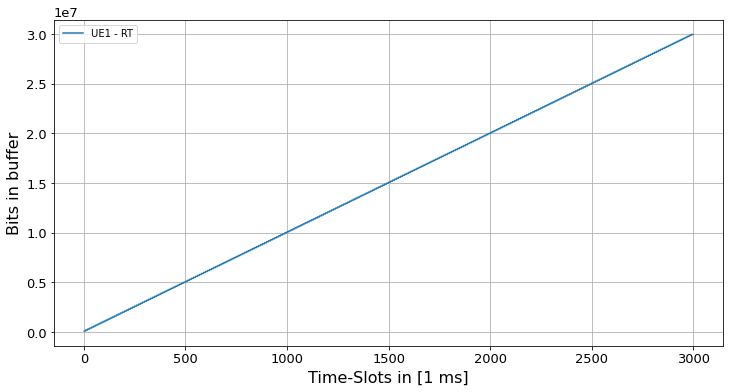

In [18]:
plt.figure(figsize=(12,6))
plt.plot(list(ue_all[20].mon.keys()),list(ue_all[20].mon.values()),label='UE1 - RT')
#plt.plot(list(ue_all[30].mon.keys()),list(ue_all[30].mon.values()),label='UE2 - RT')
#plt.plot(list(ue_all[47].mon.keys()),list(ue_all[47].mon.values()),label='UE3 - RT')
#plt.plot(list(ue_list[120].mon.keys())[1000:3000],list(ue_list[120].mon.values())[1000:3000],label='UE4')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

No handles with labels found to put in legend.


CoMP-gain 1.2213578602230801
10% Quantil: -37.76309794806578
90% Quantil: 192.30316176803834
50% Quantil (Median): -33.975093917721445


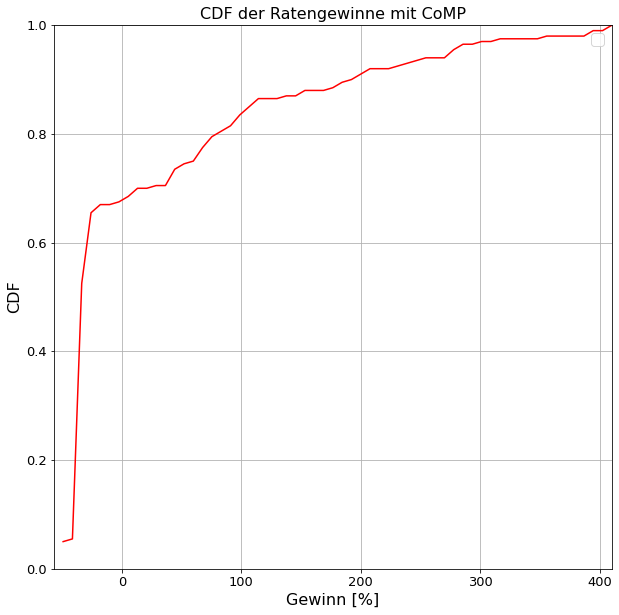

In [20]:
av=0
liste=np.array([])
for i in ue_all:
    liste=np.append(liste,((i.mR2/i.mR)-1)*100)
    av+=i.mR2/i.mR
    #print(((i.mR2/i.mR)-1)*100)
    #print(i.comp)
av=av/(ue_nr*2)
print('CoMP-gain',av)

sh.cdf_1(liste,'','red','CDF der Ratengewinne mit CoMP',min(liste),max(liste),'Gewinn [%]',60)

In [22]:
for i in ue_all:
    print(((i.mR2/i.mR)-1)*100)
    print(i.comp)

196.27075410419596
1
-21.96243511797009
1
27.750711721554723
1
-34.51059689547803
0
207.09301233400006
1
-33.6364268601789
1
-39.06014757331705
0
-37.8677988010253
0
-37.46324344456949
0
184.37513850931046
1
-35.456790520588555
0
10.383131280914126
1
-35.68779203438436
0
-38.87899658234028
0
99.7170377780707
1
-33.992735749412404
0
-37.13286073889669
0
-37.13800059192559
0
394.45438366438674
1
111.22281467613698
1
299.67047515902505
1
-35.99153079031642
0
74.61309058504982
1
-35.68530368986974
0
-37.127751472982304
0
-37.13636025859424
0
-35.46050249680641
0
-35.47614294504381
0
-35.99576609036828
0
-35.456696175044
0
-55.847473088852404
0
-37.118445566083324
0
-36.42482506459981
0
-39.05740516142554
0
-55.867126833477
0
37.84168596082815
1
253.38439278145142
1
53.770456737025626
1
-35.994029715231434
0
80.91507760235201
1
-38.89004865161469
0
47.70659699153492
1
-35.70048136422762
0
-36.77856541973278
0
-35.73392179262469
0
-36.902460024661785
0
66.91913711378102
1
-35.90593003732015


In [21]:
print('comp prb perc',prb_number_comp/(prb_number_normal+prb_number_comp))
print('comp user perc',len(ue_comp)/len(ue_all))

comp prb perc 0.56
comp user perc 0.36


In [9]:
df=df2
env=simpy.Environment()

In [10]:
df=df2
env=simpy.Environment()

ue_dict=eds.df_to_ue_lists(df,[19,20],6,env)
ue_all=np.array([])
for i in cluster:
    ue_all=np.append(ue_all,ue_dict[i])

prb_number_comp=eds.calculate_prb_number(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp

#Start processes
    
for i in cluster:
    ue_list=ue_dict[i]
    for j in np.arange(0,ue_nr):
        env.process(ue_list[j].best_effort(env,10))
        
ue_comp=np.array([]) #ues that use comp -> processed be central_scheduler
for i in cluster:
    ue_list=ue_dict[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp
    
env.process(eds.central_scheduler(env,ue_comp,SCHEDULE_T,[19,20],prb_number_comp))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_19=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    env.process(eds.scheduler(env,ue_19,SCHEDULE_T,[19,20],max_prb,ue_list,prb_number_normal,1))
    counter=counter+1
env.run(until=6000)

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

C:\Users\Caroline Zoll\EDS\edsmodified.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\edsmodified.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queu

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
empty queue -comp
empty queue -comp
empty queue -comp
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
mit CoMP
m

In [11]:
prb_number_comp

28

CoMP-gain 1.0004527760075912


No handles with labels found to put in legend.


10% Quantil: -0.13333835334339295
90% Quantil: 0.36770931105010174
50% Quantil (Median): -0.003793712008981487


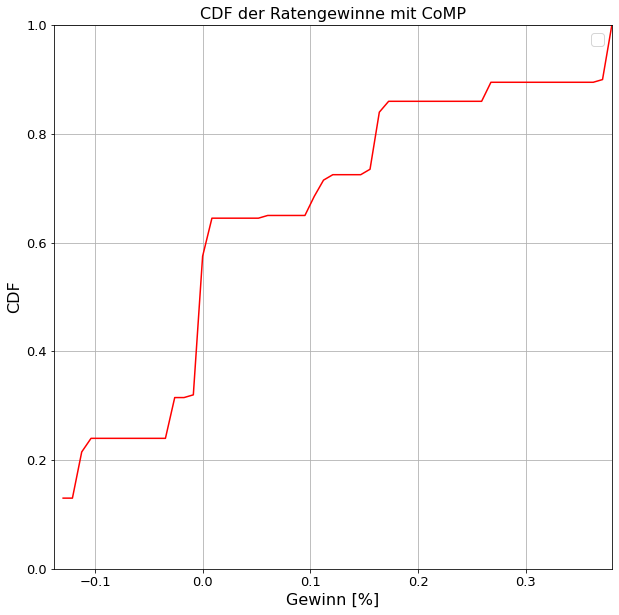

In [12]:
av=0
liste=np.array([])
for i in ue_all:
    liste=np.append(liste,((i.mR2/i.mR)-1)*100)
    av+=i.mR2/i.mR
    #print(((i.mR2/i.mR)-1)*100)
    #print(i.comp)
av=av/(ue_nr*2)
print('CoMP-gain',av)


sh.cdf_1(liste,'','red','CDF der Ratengewinne mit CoMP',min(liste),max(liste),'Gewinn [%]',60)